In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R')
    source('../R/utils.R')
})

# Preprocessing

Choose which dataset to load: 

In [2]:
## OPTION 1: Full dataset (>500,000 cells)
# exprs_norm <- readRDS('../data/figure3/exprs_full.rds')
# meta_data <- fread('../data/figure3/metadata_full.csv')

## OPTION 2: Downsample dataset (30,000 cells)
exprs_norm <- readRDS('../data/figure3/exprs_30k.rds')
meta_data <- fread('../data/figure3/metadata_30k.csv')


Select variable genes

In [3]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$tissue)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

PCA embedding

In [4]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(30)
pca_embeddings <- pca_res$v %*% diag(pca_res$d)        

UMAP embedding

In [5]:
pca_umap <- do_umap(pca_embeddings)

# Harmony

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



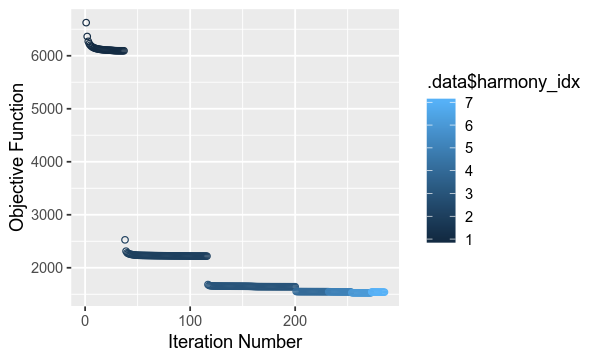

In [6]:
fig.size(3, 5)
harmony_embeddings <- HarmonyMatrix(
    pca_embeddings, 
    meta_data,
    c('tissue', 'sample_id'), 
    theta=c(1, 1), 
    do_pca=FALSE, 
    plot_convergence=TRUE
)

In [7]:
harmony_umap <- do_umap(harmony_embeddings)

# LISI 

In [8]:
lisi_res <- rbind(
    lisi::compute_lisi(harmony_embeddings, meta_data, c('tissue', 'sample_id', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embeddings, meta_data, c('tissue', 'sample_id', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, tissue, sample_id)

In [9]:
head(lisi_res)


,type,key,val
,<chr>,<chr>,<dbl>
1,harmony,cell_type,1.792007
2,harmony,cell_type,2.106341
3,harmony,cell_type,1.269548
4,harmony,cell_type,1.276030
5,harmony,cell_type,1.490323
6,harmony,cell_type,1.350078


Warning message:
“Removed 54344 rows containing non-finite values (stat_density).”


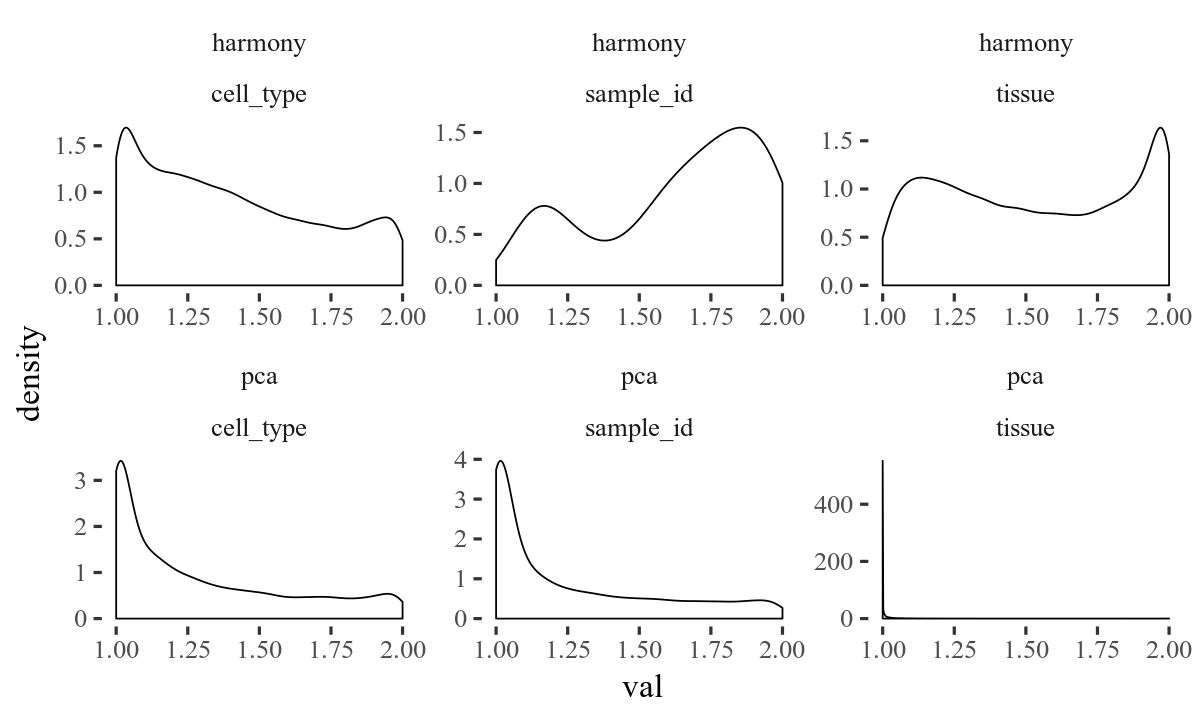

In [10]:
fig.size(6, 10)
lisi_res %>% 
    ggplot(aes(val)) + 
        geom_density() + 
        facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 20) +
        xlim(1, 2)


# Markers

It was difficult to do differential expression with >500,000 cells. I created an efficient implementation of the Wilcoxon Rank Sum test (https://github.com/immunogenomics/presto) to be able to do this efficiently. 

In [11]:
dge <- wilcoxauc(exprs_norm, factor(meta_data$cell_type))

In [12]:
top_markers(dge) %>% head(10) %>% t()

rank,1,2,3,4,5,6,7,8,9,10
Adipocytes,NEAT1,PLEKHB2,BACH1,SUPV3L1,MGRN1,PPP4R2,PTTG1IP,MALAT1,CXorf38,ECH1
CLP,IGLL1,HMGB1,STMN1,PTMA,VPREB1,SOX4,HNRNPA1,ACTG1,CD79B,H3F3A
CMP,RP11-620J15.3,PRSS57,STMN1,ANKRD28,TUBA1B,DUT,TXN,NUCB2,GAPDH,SMIM24
DC1,HLA-DRA,HLA-DRB1,HLA-DPB1,HLA-DPA1,HLA-DQB1,CD74,HLA-DMA,HLA-DQA1,HLA-DRB5,CD83
DC2,HLA-DPA1,HLA-DRA,HLA-DPB1,CST3,HLA-DRB1,HLA-DMA,HLA-DQB1,CD74,HLA-DQA1,LYZ
DC3,LYZ,CST3,LGALS1,FTL,S100A9,S100A6,S100A8,GPX1,SRGN,CSTA
DC4,LST1,AIF1,COTL1,FTL,FTH1,CST3,SAT1,PSAP,FCER1G,TYROBP
DC5,CST3,PLD4,VIM,ANXA2,PLAC8,TUBA1B,GPX1,SAMHD1,GSTP1,HLA-DMA
DC6,JCHAIN,ITM2C,SEC61B,PLD4,PLAC8,C12orf75,CD74,IRF7,IRF8,TCF4
Eosinophils,DND1,UBXN2A,MMP16,NCAPH2,WRN,RCAN2,TUSC1,SORL1,DYRK1A,SLC4A7


# Figures

In [13]:
colors_tissue <- tableau_color_pal()(2)
colors_donor <- tableau_color_pal('Tableau 20')(16)

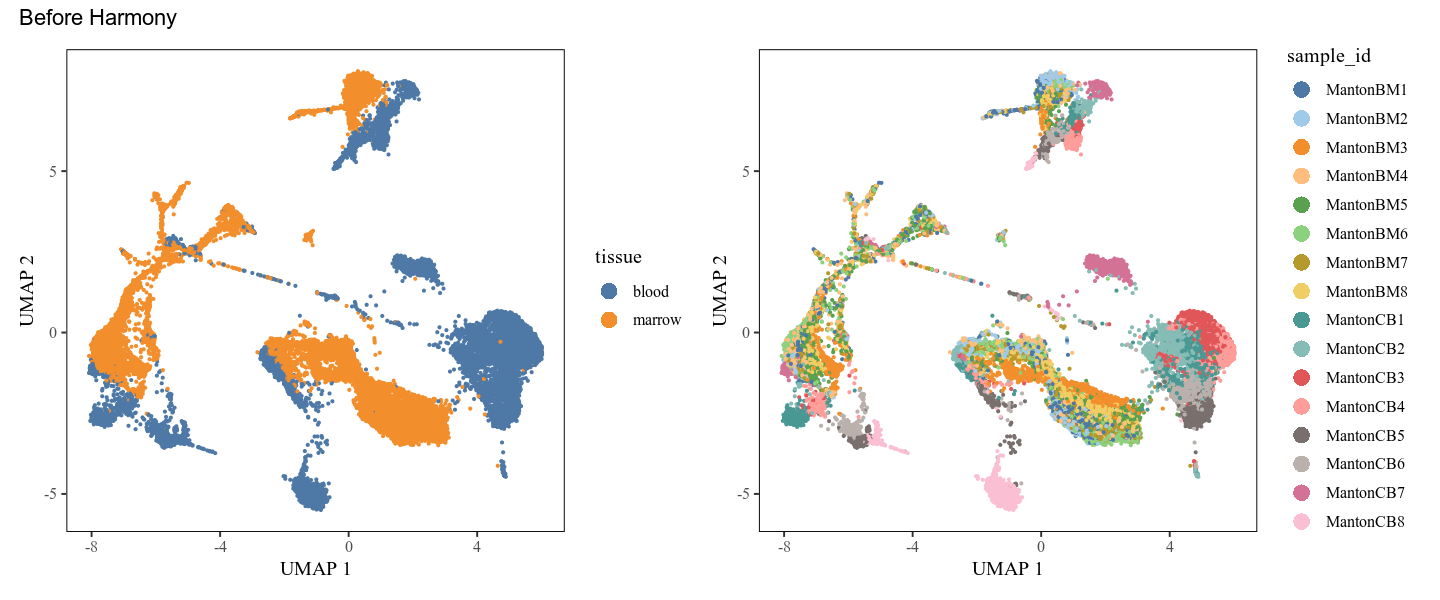

In [14]:
fig.size(5, 12)
do_scatter(pca_umap, meta_data, 'tissue', palette_use = colors_tissue, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'sample_id', palette_use = colors_donor, 
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'Before Harmony')

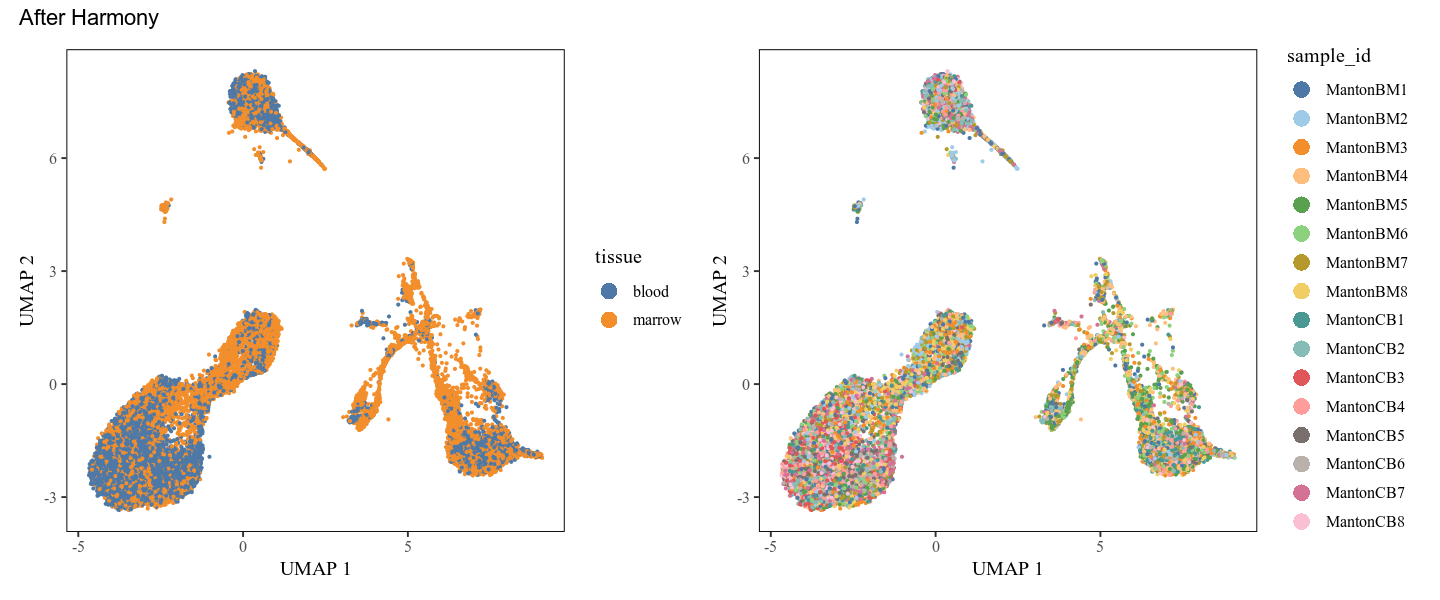

In [15]:
fig.size(5, 12)
do_scatter(harmony_umap, meta_data, 'tissue', palette_use = colors_tissue, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'sample_id', palette_use = colors_donor, 
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'After Harmony')